# Polaris

In [1]:
import aplpy
from astropy.io import fits
%pylab inline
#plt.style.use(['dark_background'])

Populating the interactive namespace from numpy and matplotlib


INFO: Auto-setting vmin to  5.465e+19 [aplpy.core]
INFO: Auto-setting vmax to  1.904e+21 [aplpy.core]


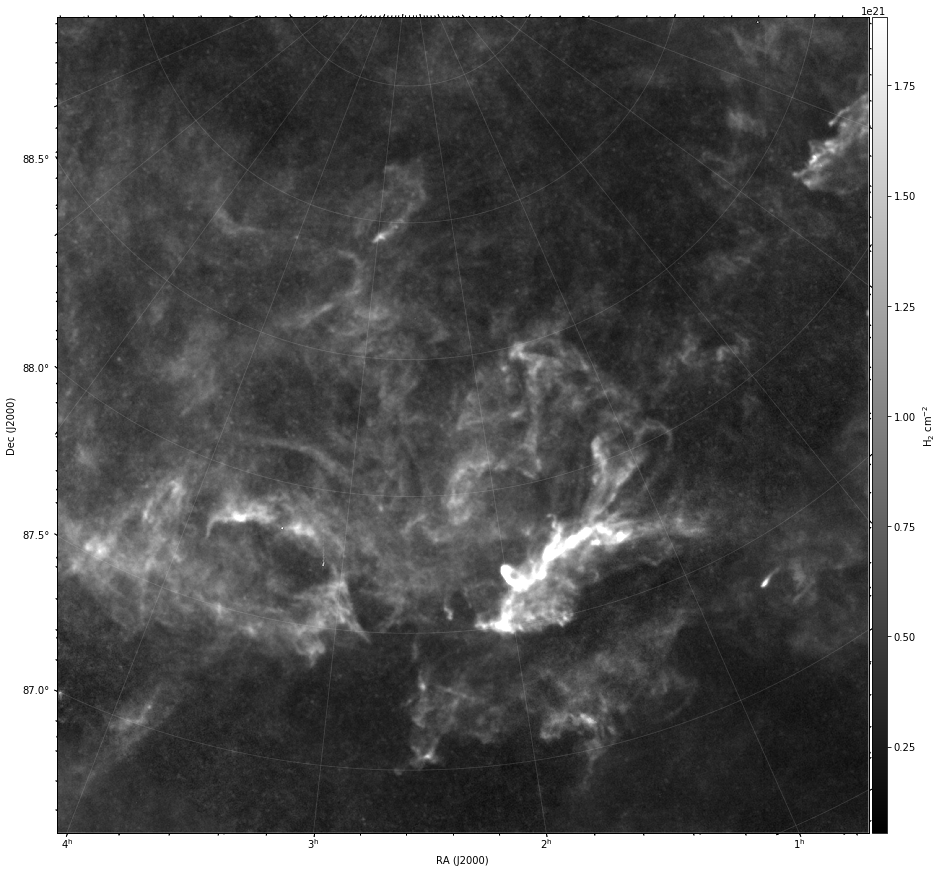

In [2]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/HGBS_polaris_cdens_rot_cut.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(15)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [3]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
from bokeh.models import LogAxis, Range1d
output_notebook()

from astropy import wcs
from powspec import powspec
from pywavan import fan_trans, apodize, padding, depad
#from rebin import congrid
from gauss_beam import gauss_beam

Loading BokehJS ...

In [4]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

Initial resolution

In [10]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
imzm = im - np.mean(im)

#Apodization

tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,4096,4096)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
FWHM = 18.2 / (60.*reso)  #Beam size at 250 micron
beam = gauss_beam(FWHM,im.shape[0],im.shape[1],FWHM=True)
beam = gauss_beam(FWHM,4096,4096,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation

#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="Scale [pc]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_k, legend='Fourier')

f.legend.location = "top_left"

showbok(f)

Rebinning to the 500 $\mu$m resolution

In [4]:
HDU2 = fits.open('/Users/robitaij/postdoc/Herschel/Gould Belt/HGBS_polaris_cdens_rot_rebin_cut.fits')
imcong = HDU2[0].data

#Resolution in arcmin
reso = HDU2[0].header['CDELT2'] * 60.

na = imcong.shape[1]
nb = imcong.shape[0]
imzm = imcong - np.mean(imcong)

#Apodization

tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,950,950)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
#FWHM = 18.2 / (60.*reso)  #Beam size at 250 micron
FWHM = 36.9 / (60.*reso)  #Beam size at 500 micron
beam = gauss_beam(FWHM,950,950,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[4]

#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
xmin = 0.003
xmax = 4.
ymin = 2 * 10**39
ymax = 3 * 10**45
f = figbok( x_axis_label="k [acrmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools, x_range=(xmin, xmax), y_range=(ymin, ymax))
f.line(tab_k, spec_k/spec_beamn, legend='Fourier')

#Set a list of q
q=[]
q=[2.5]*24
#print q

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True, skewl=0.4, apodize= 0.98, arrdim = np.array([950,950]))
print q

S1an = np.copy(S1a)

S1an[0,3:] = S1a[0,3:]/BS1an[3:]
S1an[1,3:] = S1a[1,3:]/BS1an[3:]
S1an[2,3:] = S1a[2,3:]/BS1an[3:]

f.diamond(wav_k, S1an[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k, S1an[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_k, S1an[2,:], legend='Gaussian',color='red',line_width=5)
f.circle(wav_k, S1an[2,:]+S1an[1,:], legend='Sum',color='green',line_width=2)

#Power law fit
coef,cov = np.polyfit(np.log(wav_k[8:14]),np.log(S1an[2,8:14]),deg=1,cov=True)
yfit = np.exp(coef[1])*wav_k**coef[0]

coef2,cov2 = np.polyfit(np.log(wav_k[7:19]),np.log(S1an[1,7:19]),deg=1,cov=True)
yfit2 = np.exp(coef2[1])*wav_k**coef2[0]

print "Power law Gaussian = ", coef[0], np.sqrt(np.diag(cov))
print "Power law coherent = ", coef2[0], np.sqrt(np.diag(cov2))

f.line(wav_k, yfit, legend='Fit', line_dash='dashed')
f.line(wav_k, yfit2, line_dash='dashed')

#Gaussian noise
f.line([np.min(tab_k),np.max(tab_k)], [S1an[2,18],S1an[2,18]], line_dash='dotted', color='red',legend="Gaussian noise")

print "Gaussian noise = ", S1an[2,18]

#Add axis in parsec
dist = 150.
pcmin = dist*np.tan((1./(60.*xmin))*(np.pi/180.))
pcmax = dist*np.tan((1./(60.*xmax))*(np.pi/180.))

f.extra_x_ranges = {"parsec": Range1d(start=pcmin, end=pcmax)}
f.add_layout(LogAxis(x_range_name="parsec", axis_label="Scale [pc]"), 'above')

f.legend.location = "top_right"

showbok(f)

950 950
[2.5, 2.5, 2.5, 2.5, 2.5, 1.6999999999999993, 1.6999999999999993, 1.7999999999999994, 1.7999999999999994, 1.7999999999999994, 1.7999999999999994, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995, 1.9999999999999996, 1.9999999999999996, 1.9999999999999996, 1.9999999999999996, 1.9999999999999996, 1.9999999999999996]
Power law Gaussian =  -2.9008124598782166 [0.15639377 0.38539693]
Power law coherent =  -2.393482835565554 [0.02964762 0.06201909]
Gaussian noise =  6.160996597956091e+39


Text(0.5,1,u'All scales')

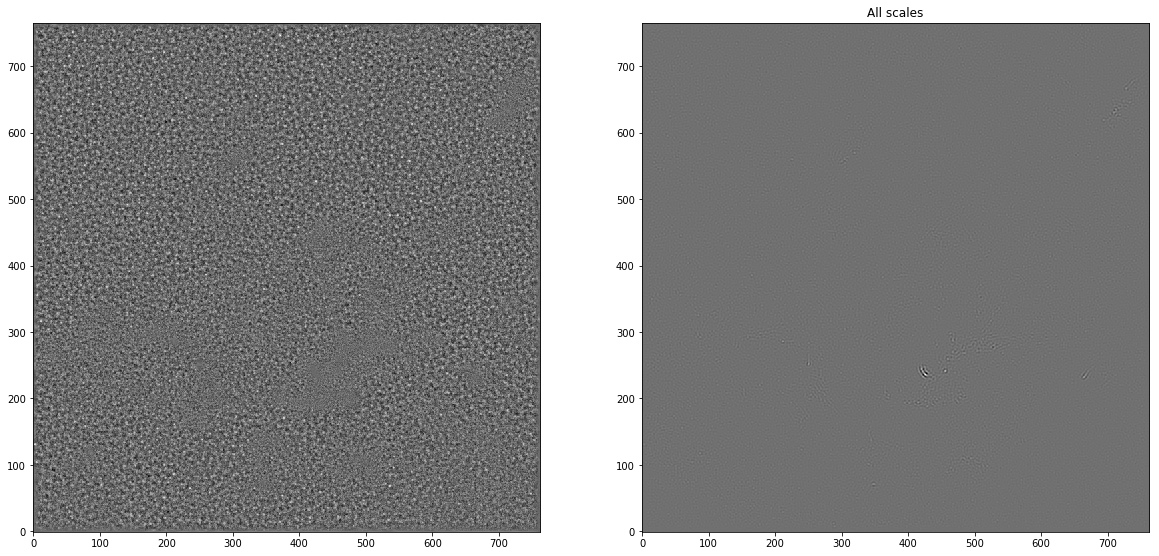

In [11]:
scl = 19

figure(figsize=(20,10))
plt.subplot(1,2,1)
imshow(np.sum(wt[2*M+15:2*M+23,:,:],axis=0).real,origin='below',cmap='gray')


plt.subplot(1,2,2)
imshow(wt[scl,:,:].real,origin='below',cmap='gray')
plt.title('All scales')

In [19]:
#Plot Beam power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="k [arcmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_beamn, legend='Fourier')
f.diamond(Bwav_k, BS1an, legend='Wavelet',color='black',line_width=5)
showbok(f)

[2.5, 2.5, 2.5, 2.5, 2.5, 1.6999999999999993, 1.6999999999999993, 1.7999999999999994, 1.7999999999999994, 1.7999999999999994, 1.7999999999999994, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995, 1.9999999999999996, 1.9999999999999996, 1.9999999999999996, 1.9999999999999996, 1.9999999999999996, 1.9999999999999996]
wav_k.shape[0]= 24


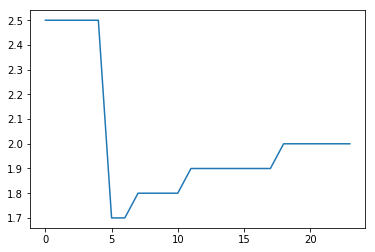

In [6]:
print q
print 'wav_k.shape[0]=',wav_k.shape[0]

x = range(24)
plot(x,np.array(q).reshape(24))

INFO: Auto-setting vmin to -4.975e+20 [aplpy.core]
INFO: Auto-setting vmax to  7.590e+20 [aplpy.core]
INFO: Auto-setting vmin to -7.503e+20 [aplpy.core]
INFO: Auto-setting vmax to  1.614e+21 [aplpy.core]


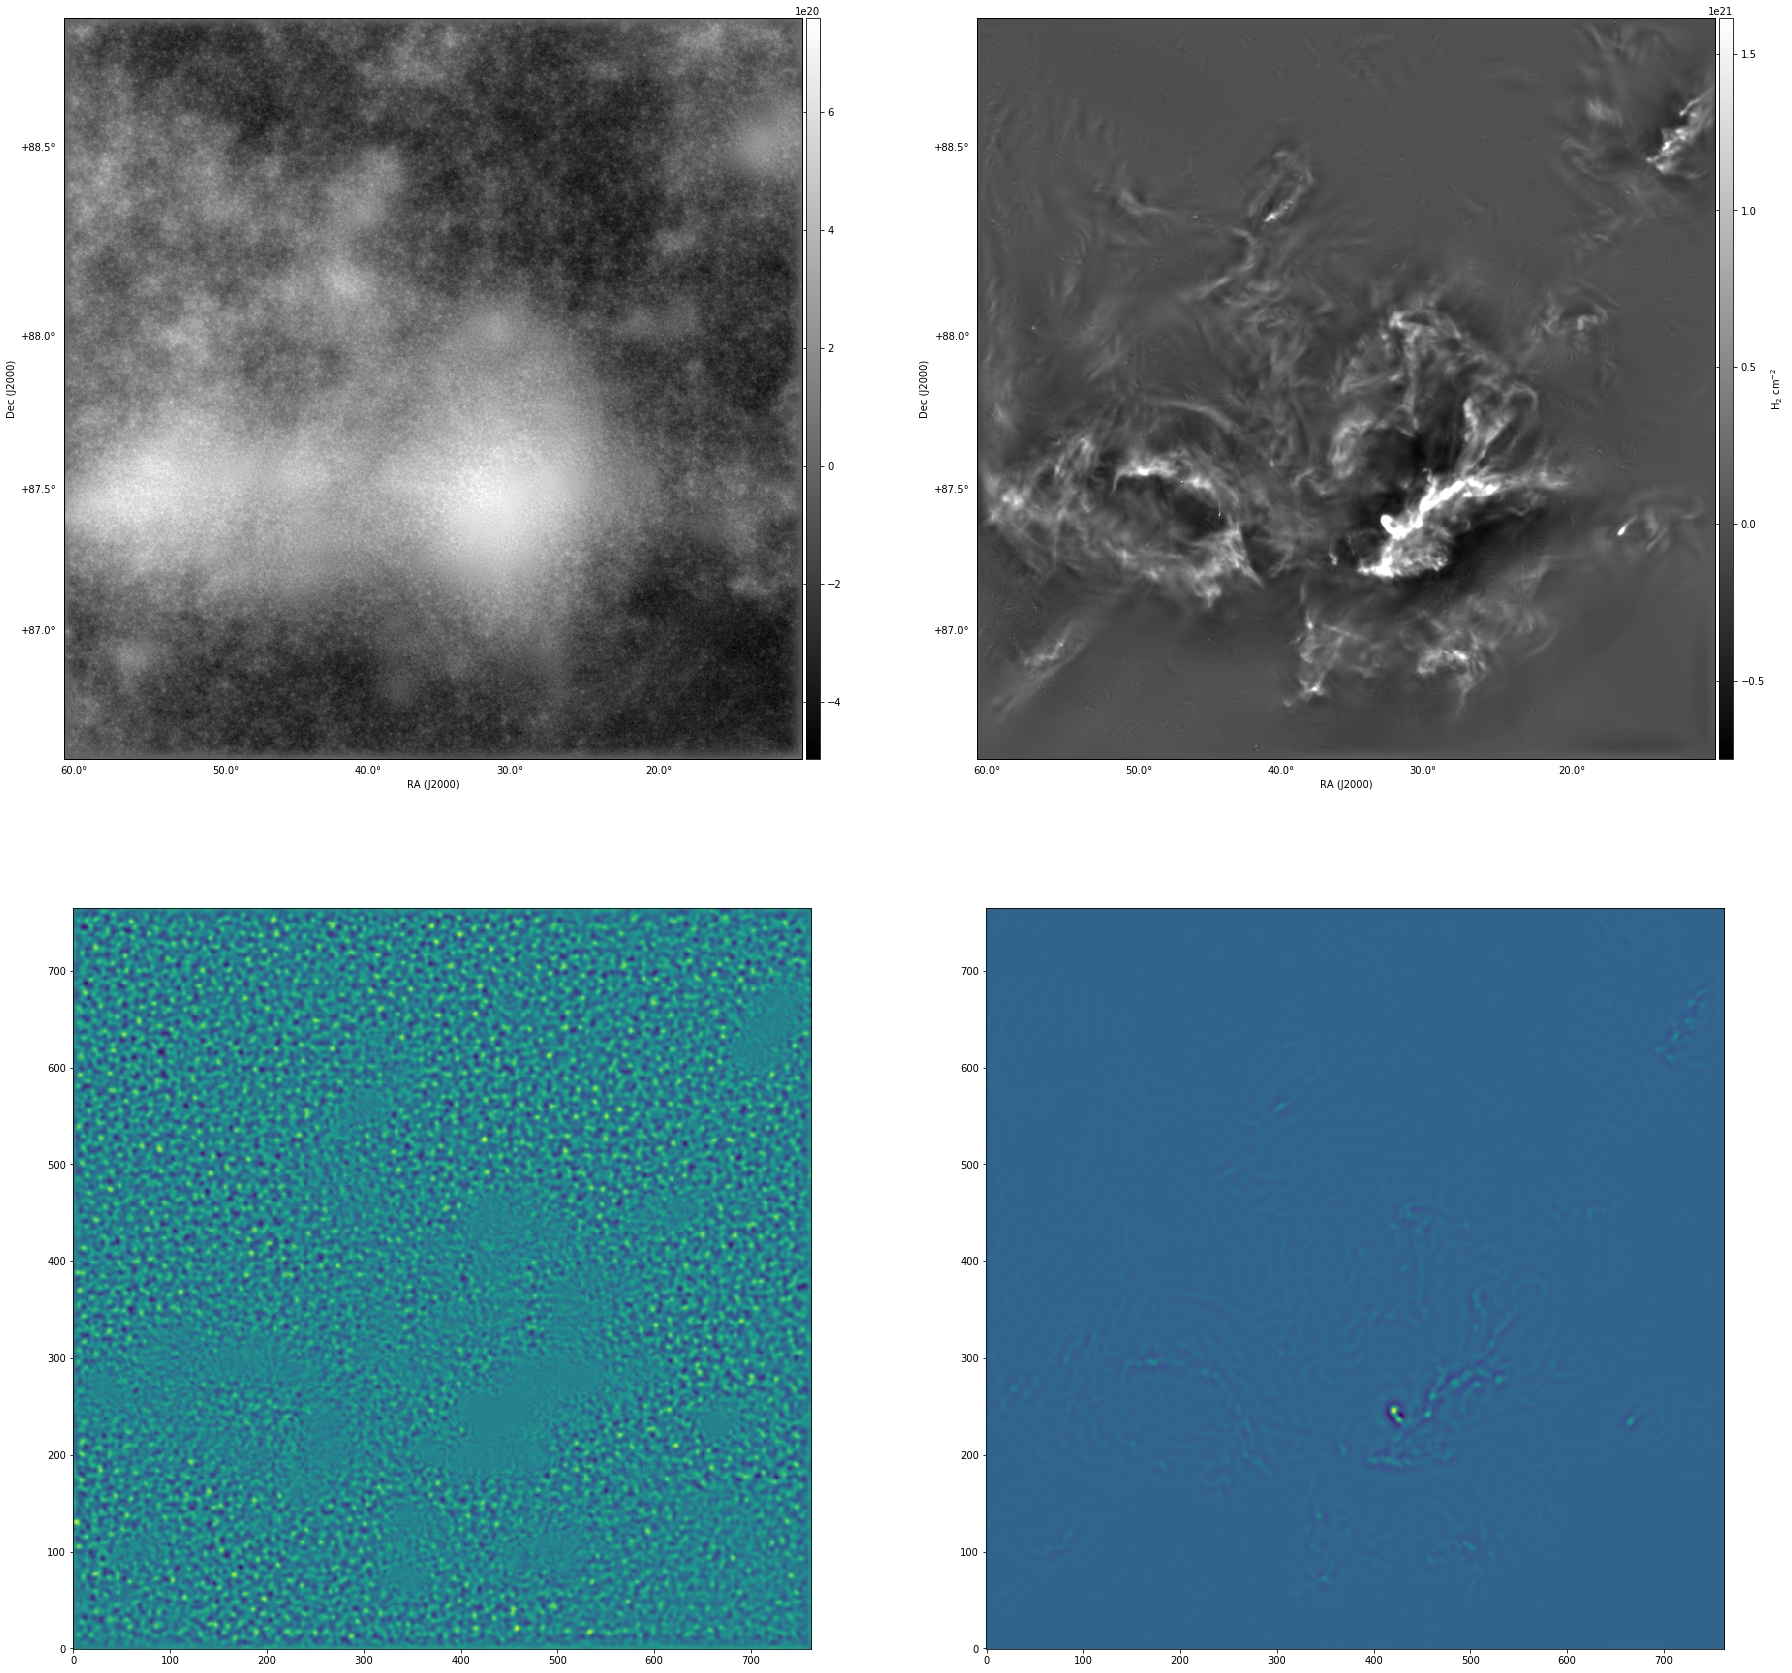

In [10]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_rbin_cohe.fits',\
            coherent.real,HDU2[0].header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_rbin_gaussian.fits',\
            Gaussian.real,HDU2[0].header,overwrite=True)

fig_all = plt.figure(1, figsize=(30,30))

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_rbin_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_rbin_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

plt.subplot(2,2,3)
imshow(np.sum(wt[2*M+14:2*M+18,:,:],axis=0).real,origin='below')

plt.subplot(2,2,4)
imshow(np.sum(wt[M+14:M+18,:,:],axis=0).real,origin='below')

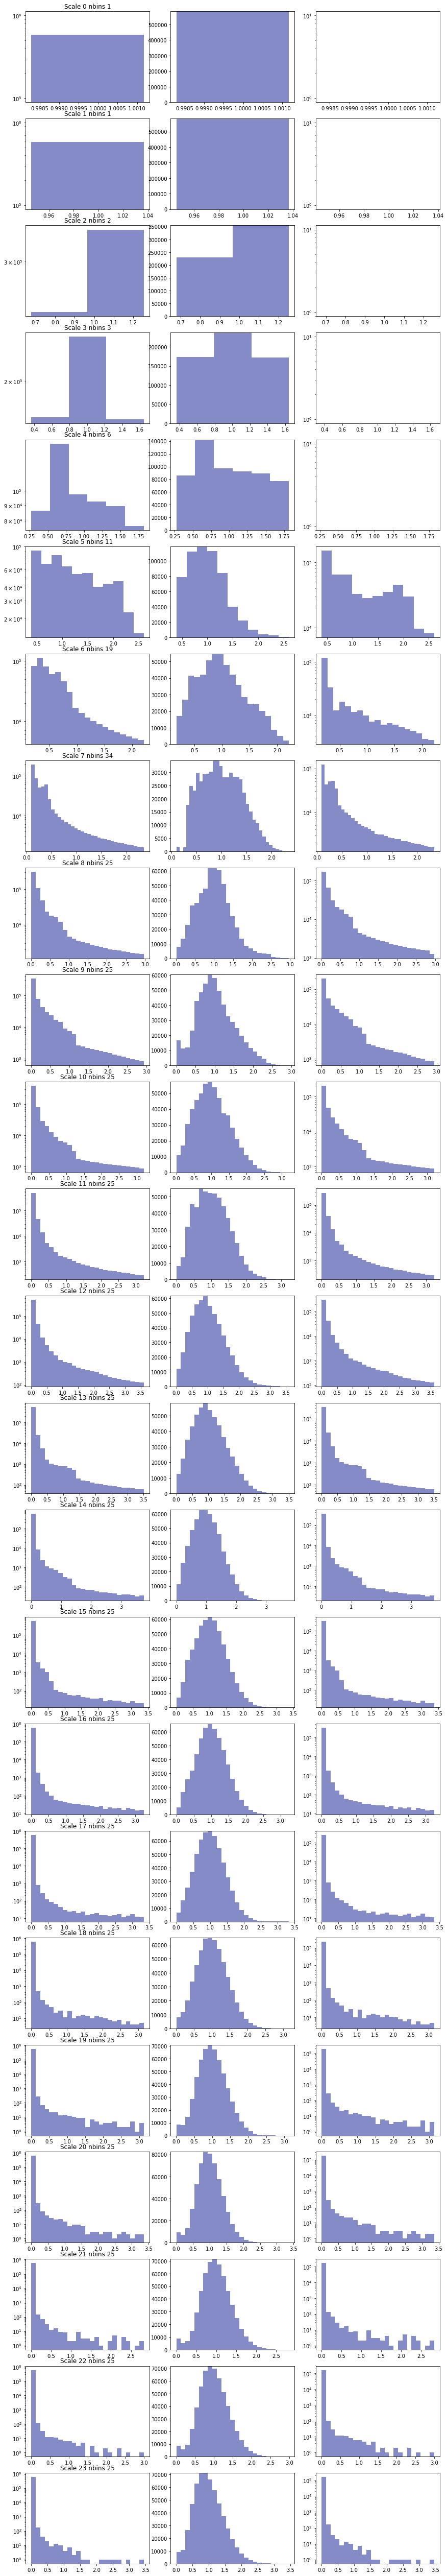

In [41]:
fig, axs = plt.subplots(M,3,figsize=(12,70))

axs = axs.ravel()
fig.tight_layout()

for i in range(M):
    
    if np.mean(S11a[M+i,:,:]) !=0:
        wc = (S11a[M+i,:,:])/np.mean(S11a[M+i,:,:])
    else:
        wc = np.zeros((imcong.shape[0],imcong.shape[1]))
    wo = (S11a[i,:,:])/np.mean(S11a[i,:,:])
    #wg = (S11a[2*M+i,0:100 & 700:,:])/np.mean(S11a[2*M+i,:,:])
    #wg = (S11a[2*M+i,100:700,:])/np.mean(S11a[2*M+i,:,:])
    wg = (S11a[2*M+i,:,:])/np.mean(S11a[2*M+i,:,:])
    
    #Number of independent points
    npix = np.int((imcong.shape[0] * wav_k[i]*reso)**2.)
    if npix == 0: nbins=1
    if npix > 0 & npix < 50 : nbins=npix
    if npix > 50 : nbins=25
    
    #histo, edges = np.histogram(np.log(wo),bins=nbins)
    #histo_c, edges = np.histogram(np.log(wc[wc != 0.]),bins=nbins)
    #histo_g, edges = np.histogram(np.log(wg[wg != 0.]),bins=nbins)
    histo, edges = np.histogram(wo,bins=nbins)
    histo_c, edges = np.histogram(wc[wc != 0.],bins=nbins)
    histo_g, edges = np.histogram(wg[wg != 0.],bins=nbins)
    
    axs[i*3].bar(edges[:-1], histo, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    axs[i*3].set_title('Scale '+np.str(i)+' nbins '+np.str(nbins))
    axs[i*3].set_yscale('log')
    
    axs[i*3+1].bar(edges[:-1], histo_g, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    axs[i*3+1].set_ylim((0,np.max(histo_g)))
    
    axs[i*3+2].bar(edges[:-1], histo_c, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    axs[i*3+2].set_yscale('log')

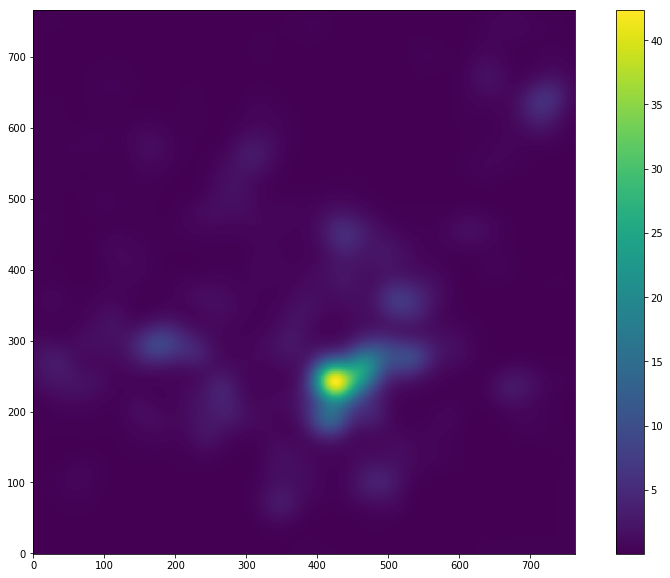

In [35]:
plt.figure(figsize=(15,10))
imshow((S11a[12,:,:])/np.mean(S11a[12,:,:]),origin='below')
plt.colorbar()

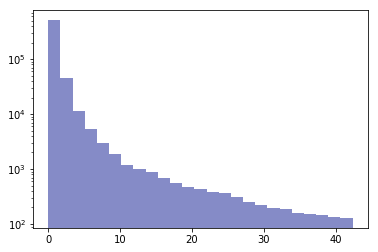

In [39]:
wo = (S11a[12,:,:])/np.mean(S11a[12,:,:])
histo, edges = np.histogram(wo,bins=nbins)
bar(edges[:-1], histo, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
yscale('log')

In [10]:
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wav_k_pola_hers.npy',wav_k)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/S1a_pola_hers.npy',S1a)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/S1an_pola_hers.npy',S1an)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wt_pola_hers.npy',wt)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/tab_k_pola_hers.npy',tab_k)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/spec_k_pola_hers.npy',spec_k)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/spec_beamn_pola_hers.npy',spec_beamn)

fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wt_pola_hers.fits',wt.real,HDU2[0].header,overwrite=True)